In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import reciprocal
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from gensim.models import Word2Vec
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, auc, roc_curve, make_scorer
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from skopt import gp_minimize
from skopt.space import Real, Categorical
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from scipy.stats import loguniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from skopt.space import Real, Categorical
import math
from sklearn.pipeline import Pipeline
import os
from joblib import dump


import warnings
warnings.filterwarnings("ignore")

C:\Users\soboc\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
processed_train_data=pd.read_csv('../data/processed data/processed_train_data.csv', encoding='ISO-8859-1')
processed_test_data=pd.read_csv('../data/processed data/processed_val_data.csv', encoding='ISO-8859-1')

In [4]:
X_train=processed_train_data.drop('target', axis=1)
y_train=processed_train_data['target']
X_test=processed_test_data.drop('target',axis=1)
y_test=processed_test_data['target']

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((505612, 3), (216619, 3), (505612,), (216619,))

In [6]:
X_train.head(), y_train.head()

(                                                text  polarity  contains_not
 0  really bore nothing not want tomoz lazy nothin... -0.656250             1
 1  run hrs sleep whoo hoo lol come around head ho...  1.000000             0
 2  think reality finally set nowin day half heart... -0.153472             0
 3                              explore twitter world  0.000000             0
 4                                  hungover make day  0.000000             0,
 0    0
 1    1
 2    0
 3    1
 4    0
 Name: target, dtype: int64)

# Features for models

## Word Embeddings

In [5]:
tokenized_sentences = [word_tokenize(text) for text in X_train['text']]

model = Word2Vec(tokenized_sentences, vector_size=100, window=7, min_count=5, sg=1)

def text_to_vector(text, embedding_model, embedding_dim):
    words = text.split()
    vectors = []
    for word in words:
        if word in embedding_model.wv:
            vectors.append(embedding_model.wv[word])
    if not vectors:
        return np.zeros(embedding_dim)
    avg_vector = np.mean(vectors, axis=0)
    return avg_vector

embedding_dim = 10

word2vec_vector = X_train['text'].apply(lambda x: text_to_vector(x, model, embedding_dim))
word2vec_vector_test = X_test['text'].apply(lambda x: text_to_vector(x, model, embedding_dim))

In [6]:
max_length = 100

def pad_or_truncate_sequences(sequences, max_length):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < max_length:
            padded_seq = np.pad(seq, (0, max_length - len(seq)), mode='constant')
        else:
            padded_seq = seq[:max_length]
        padded_sequences.append(padded_seq)
    return np.array(padded_sequences)

X_train_w2v_pad = pad_or_truncate_sequences(word2vec_vector, max_length)
X_test_w2v_pad = pad_or_truncate_sequences(word2vec_vector_test, max_length)

# Basic Models

In [7]:
numeric_features = ['contains_not', 'polarity']
text_feature = 'text'

In [8]:
def model_classification_reports(models, X_train, y_train, X_test, y_test):
    reports = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)
            roc_auc = roc_auc_score(y_test, y_score)

        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        report['roc_auc'] = roc_auc
        reports[model_name] = report
    return reports

In [9]:
def print_classification_reports(reports):
    for model_name, report in reports.items():
        print(model_name.upper())
        print('==================================')

        print('Model Performance for Test Set:')
        print('- Accuracy: {:.4f}'.format(report['accuracy']))
        print('- F1 Score: {:.4f}'.format(report['weighted avg']['f1-score']))
        print('- Precision: {:.4f}'.format(report['weighted avg']['precision']))
        print('- Recall: {:.4f}'.format(report['weighted avg']['recall']))
        print('- ROC AUC Score: {:.4f}'.format(report['roc_auc']))

        print('==================================')
        print('\n')


In [10]:
def roc_curve_plot(models, X_test, y_test):
    plt.figure(figsize=(8, 8))
    plt.title("ROC Curve for Different Models")
    for model_name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_score)
        auc = round(roc_auc_score(y_test, y_score), 4)
        plt.plot(fpr, tpr, label=f"{model_name}, AUC={auc}")
    plt.legend()


### bag of words

In [69]:
bow_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('text', CountVectorizer(max_df=0.8), text_feature)])

In [70]:
X_train_bow = bow_preprocessor.fit_transform(X_train)
X_test_bow = bow_preprocessor.transform(X_test)

In [10]:
bow_models_to_test = {
    'LinearSVC': Pipeline(steps=[('classifier', LinearSVC())]),
    'LogisticRegression': Pipeline(steps=[('classifier', LogisticRegression())]),
    'LGBMClassifier': Pipeline(steps=[('classifier', LGBMClassifier())]),
    'XGBClassifier': Pipeline(steps=[('classifier', XGBClassifier())]),
    'RandomForestClassifier': Pipeline(steps=[('classifier', RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1))]),
    'AdaBoostClassifier':  Pipeline(steps=[('classifier', AdaBoostClassifier(n_estimators=10))]),
    'RidgeClassifier':  Pipeline(steps=[('classifier', RidgeClassifier())])
}

In [12]:
reports = model_classification_reports(bow_models_to_test, X_train_bow, y_train, X_test_bow, y_test)
print_classification_reports(reports)

[LightGBM] [Info] Number of positive: 119507, number of negative: 386105
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 12.455954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23811
[LightGBM] [Info] Number of data points in the train set: 505612, number of used features: 9847
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.236361 -> initscore=-1.172734
[LightGBM] [Info] Start training from score -1.172734
LINEARSVC
Model Performance for Test Set:
- Accuracy: 0.8245
- F1 Score: 0.8141
- Precision: 0.8130
- Recall: 0.8245
- ROC AUC Score: 0.8371


LOGISTICREGRESSION
Model Performance for Test Set:
- Accuracy: 0.8319
- F1 Score: 0.8209
- Precision: 0.8212
- Recall: 0.8319
- ROC AUC Score: 0.8515


LGBMCLASSIFIER
Model Performance for Test Set:
- Accuracy: 0.8176
- F1 Score: 0.7959
- Precision: 0.8046
- Recall: 0.8176
- ROC AUC Score: 0

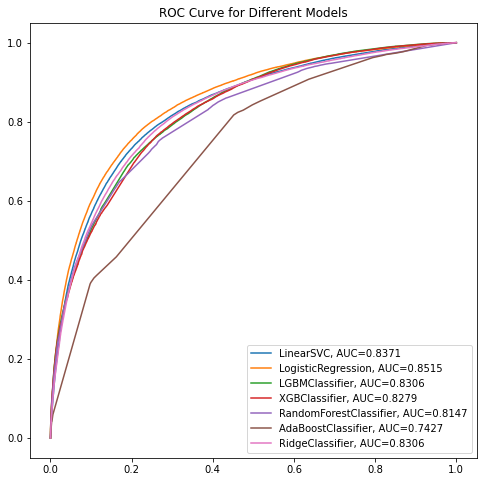

In [16]:
roc_curve_plot(bow_models_to_test, X_train_bow, y_train, X_test_bow, y_test)

### Bayes optimization for Logistic Regression

In [72]:
param_space = {
    'C': Real(1e-5, 100.0, prior='log-uniform'),
    'solver': Categorical(['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
}

bow_lr_model = LogisticRegression()

opt = BayesSearchCV(bow_lr_model,
                     param_space,
                     n_iter=20,
                     cv=5,
                     random_state=42,
                     scoring='roc_auc',
                     n_jobs=-1)
opt.fit(X_train_bow, y_train)

print("Best parameters found: ", opt.best_params_)
print("Best score found: ", opt.best_score_)

Best parameters found:  OrderedDict([('C', 1.3746626277890919), ('solver', 'saga')])
Best score found:  0.8528573664753015


In [73]:
test_score = opt.score(X_test_bow, y_test)
print("Test score: ", test_score)

Test score:  0.8543386824337968


In [74]:
best_bow_lr_estimator = opt.best_estimator_
y_pred_proba = best_bow_lr_estimator.predict_proba(X_test_bow)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Best ROC AUC:", roc_auc)

Best ROC AUC: 0.8543386824337968


In [75]:
print(classification_report(y_test, best_bow_lr_estimator.predict(X_test_bow)))

              precision    recall  f1-score   support

           0       0.85      0.94      0.90    165374
           1       0.72      0.48      0.58     51245

    accuracy                           0.83    216619
   macro avg       0.79      0.71      0.74    216619
weighted avg       0.82      0.83      0.82    216619



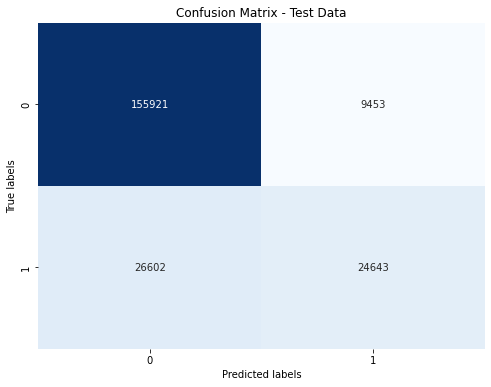

In [76]:
bow_lr_y_pred = best_bow_lr_estimator.predict(X_test_bow)
cm = confusion_matrix(y_test, bow_lr_y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Test Data")
plt.show()

In [77]:
bow_lr_best_params = opt.best_params_
print("Best parameters:")
for param, value in bow_lr_best_params.items():
    print(f"{param}: {value}")

Best parameters:
C: 1.3746626277890919
solver: saga


### Random Search for LGBM Classifier

In [86]:
param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

bow_lgbm_model=LGBMClassifier()

bow_lgbm_random_search = RandomizedSearchCV(bow_lgbm_model, param_distributions, n_iter=10, cv=5, scoring='roc_auc', random_state=42, verbose=0)
bow_lgbm_random_search.fit(X_train_bow, y_train)

In [52]:
best_params = {'subsample': 0.9, 'n_estimators': 200, 'min_child_samples': 30, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

bow_lgbm_model = LGBMClassifier(**best_params, verbose=0)
bow_lgbm_model.fit(X_train_bow, y_train)

test_score = bow_lgbm_model.score(X_test_bow, y_test)
print("Test score: ", test_score)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 119507, number of negative: 386105
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 11.843493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 505612, number of used features: 7200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.236361 -> initscore=-1.172734
[LightGBM] [Info] Start training from score -1.172734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [53]:
y_pred_proba = bow_lgbm_model.predict_proba(X_test_bow)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Best ROC AUC:", roc_auc)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Best ROC AUC: 0.8023997806959556


In [54]:
print(classification_report(y_test,bow_lgbm_model.predict(X_test_bow)))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
              precision    recall  f1-score   support

           0       0.81      0.96      0.88    165374
           1       0.72      0.29      0.41     51245

    accuracy                           0.81    216619
   macro avg       0.77      0.63      0.65    216619
weighted avg       0.79      0.81      0.77    216619



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


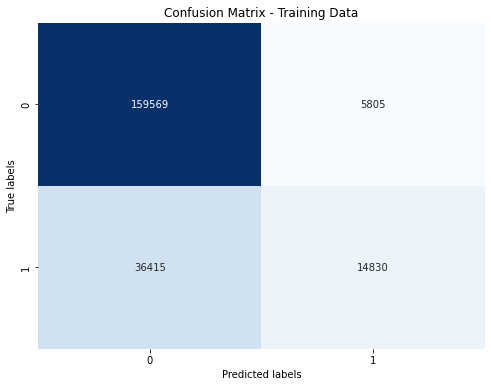

In [56]:
bow_lgbm_y_pred = bow_lgbm_model.predict(X_test_bow)
cm = confusion_matrix(y_test, bow_lgbm_y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Test Data")
plt.show()

In [55]:
bow_lgbm_best_params = bow_lgbm_model.get_params()
print("Best parameters:")
print(bow_lgbm_best_params)

Best parameters:
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 30, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [84]:
best_models = [
    bow_lgbm_model,
    best_bow_lr_estimator
]

In [85]:
os.makedirs('bow_best_models', exist_ok=True)

for model in best_models:
    model_name = model.__class__.__name__
    print(f'Saving model: {model_name}')
    model_dir = os.path.join('bow_best_models', model_name)
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, 'bow_best_models.joblib')
    dump(model, model_path)

Saving model: LGBMClassifier
Saving model: LogisticRegression


### Tf-Idf trigrams models

In [26]:
tfidf_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('text', TfidfVectorizer(ngram_range=(1, 3)), text_feature)])

In [27]:
X_train_tfidf = tfidf_preprocessor.fit_transform(X_train)
X_test_tfidf = tfidf_preprocessor.transform(X_test)

In [80]:
tfidf_models_to_test = {
    'LinearSVC': Pipeline(steps=[('classifier', LinearSVC())]),
    'LogisticRegression': Pipeline(steps=[('classifier', LogisticRegression())]),
    'LGBMClassifier': Pipeline(steps=[('classifier', LGBMClassifier())]),
    'RandomForestClassifier': Pipeline(steps=[('classifier', RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1))]),
    'AdaBoostClassifier':  Pipeline(steps=[('classifier', AdaBoostClassifier(n_estimators=10))]),
    'RidgeClassifier':  Pipeline(steps=[('classifier', RidgeClassifier())]),
    'GradientBoostingClassifier': Pipeline(steps=[('classifier', GradientBoostingClassifier(n_estimators=3, max_depth=3))])
}

In [81]:
tfidf_reports = model_classification_reports(tfidf_models_to_test, X_train_tfidf, y_train, X_test_tfidf, y_test)
print_classification_reports(tfidf_reports)

[LightGBM] [Info] Number of positive: 119507, number of negative: 386105
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 76.157083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 409868
[LightGBM] [Info] Number of data points in the train set: 505612, number of used features: 29111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.236361 -> initscore=-1.172734
[LightGBM] [Info] Start training from score -1.172734
LINEARSVC
Model Performance for Test Set:
- Accuracy: 0.8417
- F1 Score: 0.8347
- Precision: 0.8335
- Recall: 0.8417
- ROC AUC Score: 0.8691


LOGISTICREGRESSION
Model Performance for Test Set:
- Accuracy: 0.8419
- F1 Score: 0.8331
- Precision: 0.8331
- Recall: 0.8419
- ROC AUC Score: 0.8676


LGBMCLASSIFIER
Model Performance for Test Set:
- Accuracy: 0.8198
- F1 Score: 0.8007
- Precision: 0.8069
- Recall: 0.8198
- ROC AUC Score: 0.8320


RANDOMFORESTCLASSIFIER
Model Performance for Test Set:

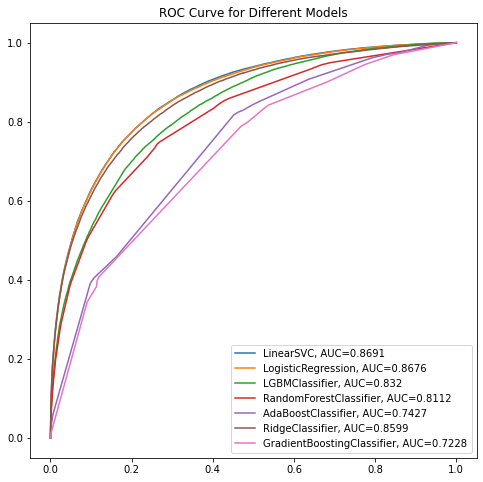

In [83]:
roc_curve_plot(tfidf_models_to_test, X_train_tfidf, y_train, X_test_tfidf, y_test)

### Linear SVC for TF-IDF

In [87]:
l_SVC_trigrams=LinearSVC(class_weight='balanced')
l_SVC_trigrams.fit(X_train_tfidf,y_train)

LinearSVC(class_weight='balanced')

In [88]:
y_pred_trigrams_test = l_SVC_trigrams.predict(X_test_tfidf)
report = classification_report(y_test, y_pred_trigrams_test, output_dict=True)

report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.894422,0.876347,0.885292,165374.000000
1,0.625387,0.666172,0.645136,51245.000000
accuracy,0.826626,0.826626,0.826626,0.826626
macro avg,0.759905,0.771260,0.765214,216619.000000
weighted avg,0.830777,0.826626,0.828479,216619.000000


### Bayes optimization for LinearSVC

In [46]:
params = {
    'C': Real(1e-4, 10.0),
    'penalty': ['l1', 'l2'],
    'tol': [1e-3, 1e-4, 1e-5],
    'dual': [False],
    'max_iter': [1000, 2000]
}

def custom_scoring_function(model, X, y):
    y_score = model.decision_function(X)
    return roc_auc_score(y, y_score)

tfidf_lSVC_model=LinearSVC()

opt = BayesSearchCV(
    estimator=tfidf_lSVC_model,
    search_spaces=params,
    scoring=custom_scoring_function,
    n_iter=10,
    cv=StratifiedKFold(n_splits=5),
    random_state=42,
    n_jobs=-1
)

opt.fit(X_train_tfidf, y_train)
print("Best parameters:", opt.best_params_)
print("Best ROC AUC:", opt.best_score_)


Best parameters: OrderedDict([('C', 5.434076336596356), ('dual', False), ('max_iter', 1496), ('penalty', 'l2'), ('tol', 0.001)])
Best ROC AUC: 0.8610376851300039


In [47]:
test_score = opt.score(X_test_tfidf, y_test)
print("Test score: ", test_score)

Test score:  0.8589201770681871


In [61]:
best_tfidf_lSVC_estimator = opt.best_estimator_

In [50]:
print(classification_report(y_test,best_tfidf_lSVC_estimator.predict(X_test_tfidf)))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89    165374
           1       0.68      0.56      0.62     51245

    accuracy                           0.83    216619
   macro avg       0.77      0.74      0.75    216619
weighted avg       0.83      0.83      0.83    216619



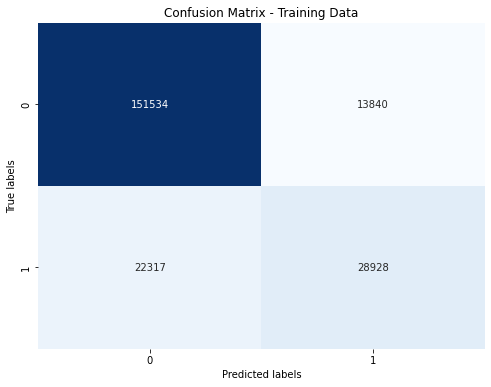

In [51]:
tfidf_lSVC_y_pred = best_tfidf_lSVC_estimator.predict(X_test_tfidf)
cm = confusion_matrix(y_test, tfidf_lSVC_y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Training Data")
plt.show()

In [52]:
tfidf_lSVC_best_params = opt.best_params_
print("Best parameters:")
for param, value in tfidf_lSVC_best_params.items():
    print(f"{param}: {value}")

Best parameters:
C: 5.434076336596356
dual: False
max_iter: 1496
penalty: l2
tol: 0.001


### Logistic Regression for Tf-Idf

In [35]:
param_space = {
    'C': Real(1e-6, 100.0, prior='log-uniform'),
    'solver': Categorical(['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    'class_weight': Categorical([None, 'balanced'])
}

def custom_scorer(model, X, y):
    y_pred_proba = model.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_pred_proba)

tfidf_lr_model = LogisticRegression()

opt = BayesSearchCV(tfidf_lr_model,
                    param_space,
                    n_iter=10,
                    scoring=custom_scorer,
                    cv=5,
                    random_state=42,
                    n_jobs=-1)

opt.fit(X_train_tfidf, y_train)

print("Best parameters found: ", opt.best_params_)
print("Best score found: ", opt.best_score_)

Best parameters found:  OrderedDict([('C', 3.1562246465541888), ('class_weight', None), ('solver', 'liblinear')])
Best score found:  0.8722807231272245


In [36]:
best_tfidf_lr_estimator = opt.best_estimator_
y_pred_proba = best_tfidf_lr_estimator.predict_proba(X_test_tfidf)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Best ROC AUC:", roc_auc)

Best ROC AUC: 0.8750119931751794


In [30]:
print(classification_report(y_test, best_tfidf_lr_estimator.predict(X_test_tfidf)))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90    165374
           1       0.73      0.55      0.63     51245

    accuracy                           0.85    216619
   macro avg       0.80      0.74      0.77    216619
weighted avg       0.84      0.85      0.84    216619



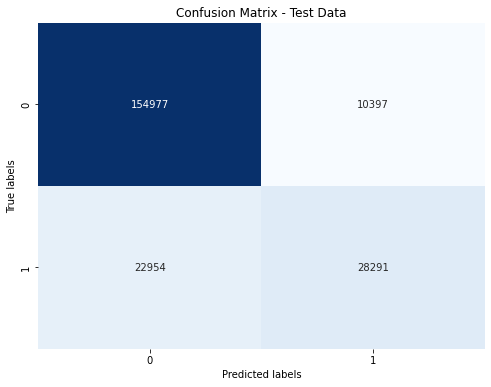

In [31]:
tfidf_lr_y_pred = best_tfidf_lr_estimator.predict(X_test_tfidf)
cm = confusion_matrix(y_test, tfidf_lr_y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Test Data")
plt.show()

In [32]:
tfidf_lr_best_params = opt.best_params_
print("Best parameters:")
for param, value in tfidf_lr_best_params.items():
    print(f"{param}: {value}")

Best parameters:
C: 3.1562246465541888
class_weight: None
solver: liblinear


### Ridge for Tf-Idf

In [36]:
params = {
    'alpha': Real(1e-4, 10.0), 
    'solver': ['auto', 'sparse_cg', 'sag'],
    'tol': [1e-3, 1e-4, 1e-5],
    'max_iter': [1000, 1500, 2000]
}
opt = BayesSearchCV(
    estimator=RidgeClassifier(),
    search_spaces=params,
    scoring='roc_auc',
    n_iter=10,
    cv=StratifiedKFold(n_splits=10),
    random_state=42,
    n_jobs=-1
)

opt.fit(X_train_tfidf, y_train)
print("Best parameters:", opt.best_params_)
print("Best ROC AUC:", opt.best_score_)

Best parameters: OrderedDict([('alpha', 4.101098578137253), ('max_iter', 2000), ('solver', 'sag'), ('tol', 0.001)])
Best ROC AUC: 0.859791428615335


In [37]:
best_tfidf_ridge_estimator = opt.best_estimator_
y_scores = best_tfidf_ridge_estimator.decision_function(X_test_tfidf)

roc_auc = roc_auc_score(y_test, y_scores)
print("Best ROC AUC:", roc_auc)

Best ROC AUC: 0.8619121088448374


In [38]:
print(classification_report(y_test,best_tfidf_ridge_estimator.predict(X_test_tfidf)))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90    165374
           1       0.75      0.48      0.59     51245

    accuracy                           0.84    216619
   macro avg       0.80      0.72      0.74    216619
weighted avg       0.83      0.84      0.83    216619



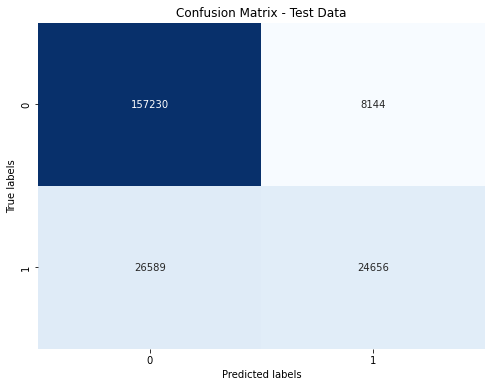

In [39]:
tfidf_ridge_y_pred = best_tfidf_ridge_estimator.predict(X_test_tfidf)
cm = confusion_matrix(y_test, tfidf_ridge_y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Test Data")
plt.show()

In [40]:
best_tfidf_ridge_params = opt.best_params_
print("Best parameters:")
for param, value in best_tfidf_ridge_params.items():
    print(f"{param}: {value}")

Best parameters:
alpha: 4.101098578137253
max_iter: 2000
solver: sag
tol: 0.001


### RandomSearch for LinearSVC

In [54]:
param_grid = {
    'C': reciprocal(0.1, 10),
    'penalty': ['l1', 'l2'],
    'dual': [False],
    'tol': [1e-3, 1e-4],
    'max_iter': [1000]
}

roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)

random = RandomizedSearchCV(estimator=l_SVC_trigrams, param_distributions=param_grid,
                            cv=3, n_jobs=-1, n_iter=5, scoring=roc_auc_scorer)

with tqdm(total=5, desc="Random Grid Search") as pbar:
    random_result = random.fit(X_train_tfidf, y_train)
    pbar.update(1)

print("Best ROC AUC score: %f using %s" % (random_result.best_score_, random_result.best_params_))

Random Grid Search:  20%|████████████▌                                                  | 1/5 [09:17<37:11, 557.91s/it]

Best ROC AUC score: 0.788498 using {'C': 0.311954562091293, 'dual': False, 'max_iter': 1000, 'penalty': 'l1', 'tol': 0.0001}


In [62]:
params = {'C': 0.311954562091293,
          'dual': False,
          'max_iter': 1000,
          'penalty': 'l1',
          'tol': 0.0001}

svc_model = LinearSVC(**params)

svc_model.fit(X_train_tfidf, y_train)

LinearSVC(C=0.311954562091293, dual=False, penalty='l1')

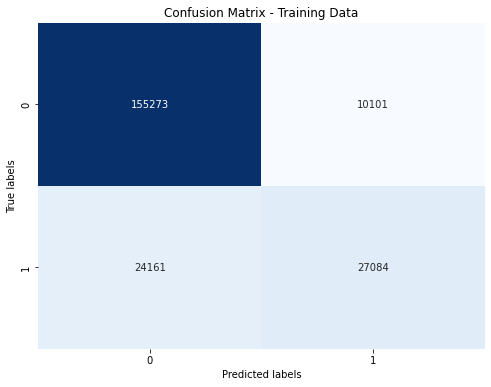

In [63]:
y_pred = svc_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Training Data")
plt.show()

## Saving best models for Tf-Idf

In [66]:
best_models={
    'LogisticRegression': best_tfidf_lr_estimator,
    'RidgeRegression': best_tfidf_ridge_estimator,
    'LinearSVC_bayes': best_tfidf_lSVC_estimator,
    'LinearSVC_random': svc_model
}

In [67]:
os.makedirs('tfidf_best_models', exist_ok=True)
for model_name, model in best_models.items():
    print(f'Saving model: {model_name}')
    model_dir = os.path.join('tfidf_best_models', model_name)
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f'{model_name}_best_model.joblib')
    dump(model, model_path)

Saving model: LogisticRegression
Saving model: RidgeRegression
Saving model: LinearSVC_bayes
Saving model: LinearSVC_random


## Word embeddings

In [27]:
word_embeddings_models_to_test = {
    'LinearSVC': Pipeline(steps=[('classifier', LinearSVC())]),
    'LogisticRegression': Pipeline(steps=[('classifier', LogisticRegression())]),
    'LGBMClassifier': Pipeline(steps=[('classifier', LGBMClassifier())]),
    'RandomForestClassifier': Pipeline(steps=[('classifier', RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1))]),
    'AdaBoostClassifier':  Pipeline(steps=[('classifier', AdaBoostClassifier(n_estimators=10))]),
    'RidgeClassifier':  Pipeline(steps=[('classifier', RidgeClassifier())]),
    'GradientBoostingClassifier': Pipeline(steps=[('classifier', GradientBoostingClassifier(n_estimators=3, max_depth=3))])
}

In [28]:
word_embeddings_reports = model_classification_reports(word_embeddings_models_to_test, X_train_w2v_pad, y_train, X_test_w2v_pad, y_test)
print_classification_reports(word_embeddings_reports)

[LightGBM] [Info] Number of positive: 119507, number of negative: 386105
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.318912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 505612, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.236361 -> initscore=-1.172734
[LightGBM] [Info] Start training from score -1.172734
LINEARSVC
Model Performance for Test Set:
- Accuracy: 0.8167
- F1 Score: 0.7891
- Precision: 0.8071
- Recall: 0.8167
- ROC AUC Score: 0.8192


LOGISTICREGRESSION
Model Performance for Test Set:
- Accuracy: 0.8188
- F1 Score: 0.7967
- Precision: 0.8065
- Recall: 0.8188
- ROC AUC Score: 0.8207


LGBMCLASSIFIER
Model Performance for Test Set:
- Accuracy: 0.8191
- F1 Score: 0.7964
- Precision: 0.8072
- Recall: 0.8191
- ROC AUC Score: 0.8277


RANDOMFORESTCLASSIFIER
Model Performance for Test Set:
- A

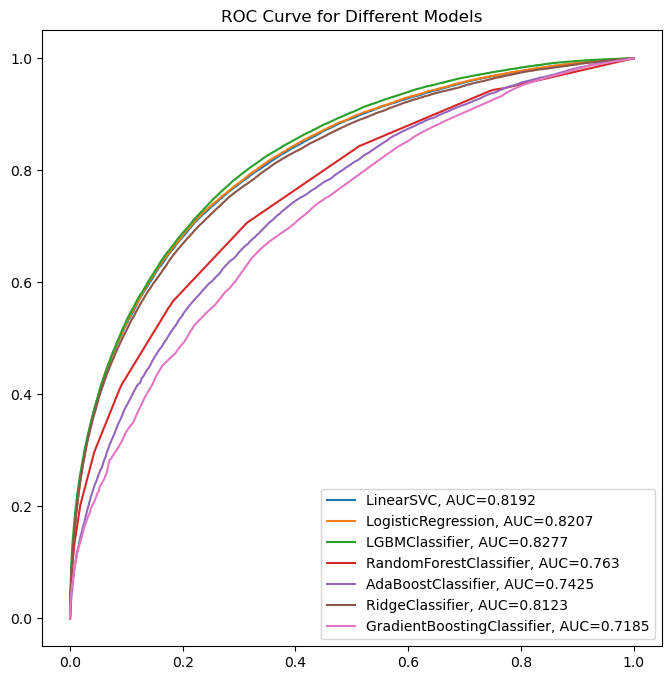

In [30]:
roc_curve_plot(word_embeddings_models_to_test, X_test_w2v_pad, y_test)

### Bayes optimization for LinearSVC

In [11]:
params = {
    'C': Real(1e-4, 10.0),
    'penalty': ['l1', 'l2'],
    'tol': [1e-3, 1e-4, 1e-5],
    'dual': [False],
    'max_iter': [1000, 2000]
}

def custom_scoring_function(model, X, y):
    y_score = model.decision_function(X)
    return roc_auc_score(y, y_score)

word_embeddings_lSVC_model=LinearSVC()

opt = BayesSearchCV(
    estimator=word_embeddings_lSVC_model,
    search_spaces=params,
    scoring=custom_scoring_function,
    n_iter=10,
    cv=StratifiedKFold(n_splits=5),
    random_state=42,
    n_jobs=-1
)

opt.fit(X_train_w2v_pad, y_train)
print("Best parameters:", opt.best_params_)
print("Best ROC AUC:", opt.best_score_)


Best parameters: OrderedDict([('C', 4.4483806397602885), ('dual', False), ('max_iter', 1105), ('penalty', 'l1'), ('tol', 0.001)])
Best ROC AUC: 0.8188475738377289


In [12]:
test_score = opt.score(X_test_w2v_pad, y_test)
print("Test score: ", test_score)

Test score:  0.8176089283264885


In [13]:
best_word_embeddings_lSVC_estimator = opt.best_estimator_
print(classification_report(y_test,best_word_embeddings_lSVC_estimator.predict(X_test_w2v_pad)))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89    165374
           1       0.75      0.33      0.46     51245

    accuracy                           0.81    216619
   macro avg       0.78      0.65      0.67    216619
weighted avg       0.80      0.81      0.79    216619



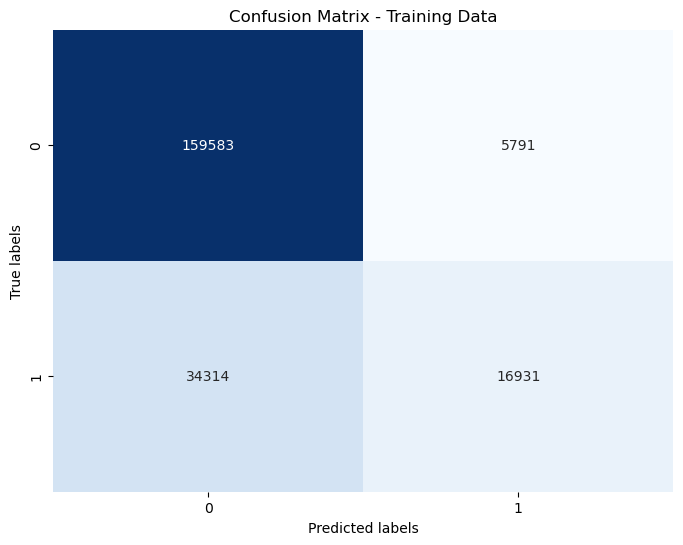

In [14]:
word_embeddings_lSVC_y_pred = best_word_embeddings_lSVC_estimator.predict(X_test_w2v_pad)
cm = confusion_matrix(y_test, word_embeddings_lSVC_y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Training Data")
plt.show()

### Logistic Regression for Word Embeddings

In [16]:
param_space = {
    'C': Real(1e-6, 100.0, prior='log-uniform'),
    'solver': Categorical(['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    'class_weight': Categorical([None, 'balanced'])
}

def custom_scorer(model, X, y):
    y_pred_proba = model.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_pred_proba)

word_embeddings_lr_model = LogisticRegression()

opt = BayesSearchCV(word_embeddings_lr_model,
                    param_space,
                    n_iter=10,
                    scoring=custom_scorer,
                    cv=5,
                    random_state=42,
                    n_jobs=-1)

opt.fit(X_train_w2v_pad, y_train)

print("Best parameters found: ", opt.best_params_)
print("Best score found: ", opt.best_score_)

Best parameters found:  OrderedDict([('C', 44.037625157309144), ('class_weight', 'balanced'), ('solver', 'saga')])
Best score found:  0.8206962209558905


In [17]:
best_word_embeddings_lr_estimator = opt.best_estimator_
y_pred_proba = best_word_embeddings_lr_estimator.predict_proba(X_test_w2v_pad)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Best ROC AUC:", roc_auc)

Best ROC AUC: 0.8196145950002072


In [18]:
print(classification_report(y_test, best_word_embeddings_lr_estimator.predict(X_test_w2v_pad)))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82    165374
           1       0.48      0.74      0.58     51245

    accuracy                           0.75    216619
   macro avg       0.69      0.74      0.70    216619
weighted avg       0.80      0.75      0.76    216619



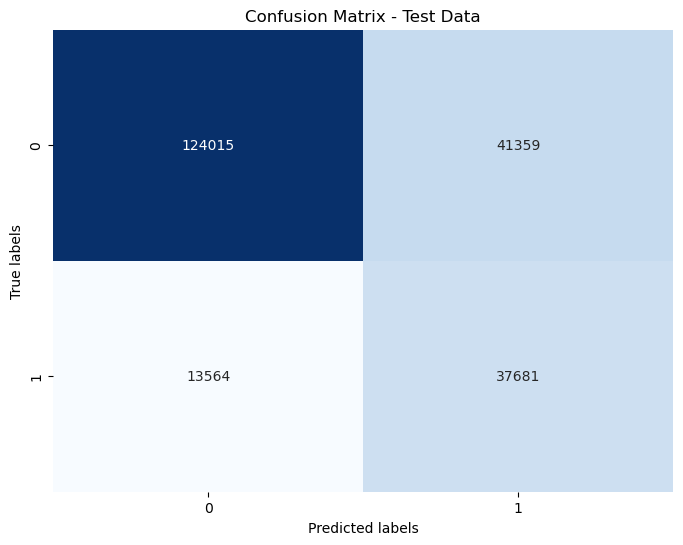

In [19]:
word_embeddings_lr_y_pred = best_word_embeddings_lr_estimator.predict(X_test_w2v_pad)
cm = confusion_matrix(y_test, word_embeddings_lr_y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Test Data")
plt.show()

### Ridge for Word Embeddings

In [20]:
params = {
    'alpha': Real(1e-4, 10.0), 
    'solver': ['auto', 'sparse_cg', 'sag'],
    'tol': [1e-3, 1e-4, 1e-5],
    'max_iter': [1000, 1500, 2000]
}
opt = BayesSearchCV(
    estimator=RidgeClassifier(),
    search_spaces=params,
    scoring='roc_auc',
    n_iter=10,
    cv=StratifiedKFold(n_splits=10),
    random_state=42,
    n_jobs=-1
)

opt.fit(X_train_w2v_pad, y_train)
print("Best parameters:", opt.best_params_)
print("Best ROC AUC:", opt.best_score_)

Best parameters: OrderedDict([('alpha', 9.554784315300653), ('max_iter', 2000), ('solver', 'sag'), ('tol', 0.0001)])
Best ROC AUC: 0.8122302791714058


In [21]:
best_word_embeddings_ridge_estimator = opt.best_estimator_
y_scores = best_word_embeddings_ridge_estimator.decision_function(X_test_w2v_pad)

roc_auc = roc_auc_score(y_test, y_scores)
print("Best ROC AUC:", roc_auc)

Best ROC AUC: 0.81077946575692


In [22]:
print(classification_report(y_test,best_word_embeddings_ridge_estimator.predict(X_test_w2v_pad)))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89    165374
           1       0.78      0.27      0.40     51245

    accuracy                           0.81    216619
   macro avg       0.80      0.62      0.65    216619
weighted avg       0.81      0.81      0.77    216619



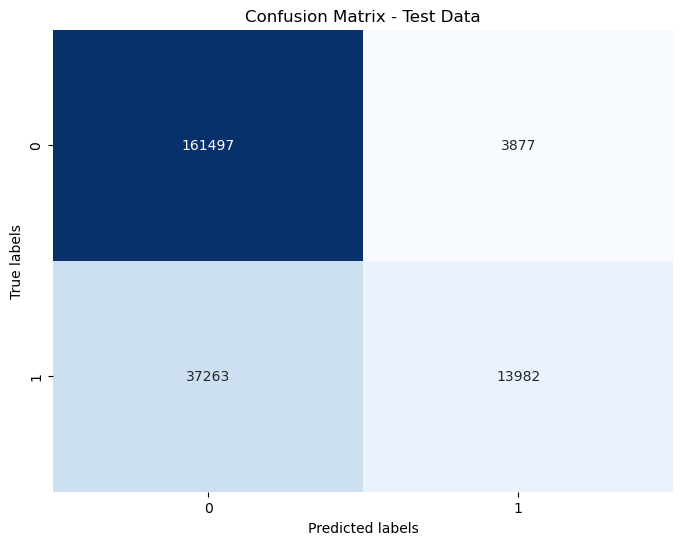

In [23]:
word_embeddings_ridge_y_pred = best_word_embeddings_ridge_estimator.predict(X_test_w2v_pad)
cm = confusion_matrix(y_test, word_embeddings_ridge_y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Test Data")
plt.show()

In [31]:
best_models={
    'LogisticRegression': best_word_embeddings_lr_estimator,
    'RidgeRegression': best_word_embeddings_ridge_estimator,
    'LinearSVC_bayes': best_word_embeddings_lSVC_estimator
}

In [32]:
os.makedirs('word_embeddings_best_models', exist_ok=True)
for model_name, model in best_models.items():
    print(f'Saving model: {model_name}')
    model_dir = os.path.join('word_embeddings_best_models', model_name)
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f'{model_name}_best_model.joblib')
    dump(model, model_path)

Saving model: LogisticRegression
Saving model: RidgeRegression
Saving model: LinearSVC_bayes


### Hyperparameters for logistic regression for Word Embeddings

In [76]:
grid = {"C": np.logspace(-3, 3, 7), "penalty": ["l1", "l2"], "solver": ["liblinear", "saga"]}
logreg_wordembedding=LogisticRegression(max_iter=100)
logreg_cv_wordembedding=GridSearchCV(logreg_wordembedding,grid,cv=3,verbose=3,refit=True)
logreg_cv_wordembedding.fit(X_train_w2v_pad,y_train)

print("tuned hpyerparameters :(best parameters) ", logreg_cv_wordembedding.best_params_)
print("accuracy :",logreg_cv_wordembedding.best_score_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV 1/3] END C=0.001, penalty=l1, solver=liblinear;, score=0.789 total time=   4.7s
[CV 2/3] END C=0.001, penalty=l1, solver=liblinear;, score=0.789 total time=   5.3s
[CV 3/3] END C=0.001, penalty=l1, solver=liblinear;, score=0.788 total time=   4.2s
[CV 1/3] END ..C=0.001, penalty=l1, solver=saga;, score=0.789 total time=  11.4s
[CV 2/3] END ..C=0.001, penalty=l1, solver=saga;, score=0.789 total time=  11.3s
[CV 3/3] END ..C=0.001, penalty=l1, solver=saga;, score=0.788 total time=  10.9s
[CV 1/3] END C=0.001, penalty=l2, solver=liblinear;, score=0.802 total time=   3.9s
[CV 2/3] END C=0.001, penalty=l2, solver=liblinear;, score=0.803 total time=   3.9s
[CV 3/3] END C=0.001, penalty=l2, solver=liblinear;, score=0.801 total time=   3.7s
[CV 1/3] END ..C=0.001, penalty=l2, solver=saga;, score=0.802 total time=   9.2s
[CV 2/3] END ..C=0.001, penalty=l2, solver=saga;, score=0.802 total time=   9.6s
[CV 3/3] END ..C=0.001, penalt

### Random Forest for TFIDF

In [69]:
X_train_rf_1, _, y_train_rf_1, _ = train_test_split(tfidf_vector_train, y_train, test_size=0.5, random_state=42)

rf_model_1 = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)
rf_model_1.fit(X_train_rf_1, y_train_rf_1)

y_pred_rf_1 = rf_model_1.predict(tfidf_vector_test)

accuracy_rf_1 = accuracy_score(y_test, y_pred_rf_1)
print("Accuracy Random Forest:", accuracy_rf_1)


Accuracy Random Forest: 0.8176291091732489


### Random Forest for word embeddings

In [74]:
X_train_rf_2, _, y_train_rf_2, _ = train_test_split(X_train_w2v_pad, y_train, test_size=0.5, random_state=42)

rf_model_2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_2.fit(X_train_rf_2, y_train_rf_2)

y_pred_rf_2 = rf_model_2.predict(X_test_w2v_pad)

accuracy_rf_2 = accuracy_score(y_test, y_pred_rf_2)
print("Accuracy Random Forest:", accuracy_rf_2)


Accuracy Random Forest: 0.8115816248805506


In [83]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

nb_model = MultinomialNB()
nb_model.fit(tfidf_vector_train, y_train)

y_pred_nb = nb_model.predict(tfidf_vector_test)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Accuracy Multinomial Naive Bayes:", accuracy_nb)


Accuracy Multinomial Naive Bayes: 0.7839063055410652
